### This is a preparation of the DeepFM with Tensorflow

- Using the customized Tensorflow functions


### Consideration

- Model Considerations
  1. Initialization Method
     - Glorut
     - **He**
       - ReLu, LeakyReLu, Swish
  2. Activation Function
     - **ReLu**
       - 계산 리소스가 제한될 때
     - **Leaky ReLu**
       - ReLu가 성능이 안좋을때
     - **Swish**
       - 계산량 많은데 성능은 좋음
  3. Batch Normalization
     - stablize the training
     - Apply between the hidden layer and the activation -> no need to apply the bias
  4. Gradient Clipping (opt)
  5. Optimizer
     - **Adam**
       - 기본 옵션
     - **AdamW**
       - 오버피팅 방지용
       - l2 는 못쓰지만 l1은 사용 가능
     - **Nadam**
       - 빠른 훈련이 필요 할 때
  6. Learning Rate Scheduling
     - Performance Base
     - 1Cycle
  7. Custom Loss Function
     - CB-BCE + Ranking Loss
       - Class-Balanced Binary Cross-Entropy (CB-BCE):
         - 클래스 불균형 문제를 해결하기 위해 라벨 빈도에 따라 가중치를 적용.
       - Ranking Loss:
         - 라벨 간 상관관계를 반영하여, 올바른 라벨의 점수가 잘못된 라벨의 점수보다 높도록 학습.


In [8]:
import tensorflow as tf
import numpy as np


# --- 0. 커스텀 F1 스코어 메트릭 정의 ---
class F1Score(tf.keras.metrics.Metric):
    """
    커스텀 F1 스코어 메트릭 클래스.
    이 메트릭은 이진 멀티레이블 분류 문제에서, sigmoid 출력에 대해 threshold 이상의 값을 1로 판단하여
    micro F1 스코어를 계산합니다.
    """
    def __init__(self, threshold=0.5, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        """
        현재 배치의 예측 결과와 실제 레이블을 사용해 true positive, false positive, false negative 값을 업데이트.
        """
        y_pred = tf.cast(tf.greater_equal(y_pred, self.threshold), tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        tp = tf.reduce_sum(y_true * y_pred)
        fp = tf.reduce_sum((1 - y_true) * y_pred)
        fn = tf.reduce_sum(y_true * (1 - y_pred))
        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        """
        현재까지 누적된 값을 바탕으로 F1 스코어 계산.
        """
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
        return f1

    def reset_states(self):
        """
        에포크가 끝날 때마다 누적 변수를 초기화.
        """
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)
        
# =============================================================================
# 1. 라벨 가중치 계산 함수 (Median Frequency Balancing)
# =============================================================================
def compute_label_weights(label_counts):
    """
    label_counts: 예시 {"A": 99, "B": 10, ...} 와 같이 각 라벨의 발생 횟수를 담은 dict.
    각 라벨의 가중치는 median frequency balancing 기법으로 
      weight = median(counts) / count
    계산됨.
    
    반환값: 라벨 순서(알파벳 정렬 등, 데이터셋에 맞춰 순서를 맞출 것)대로 tf.constant.
    """
    counts = np.array(list(label_counts.values()))
    median_count = np.median(counts)
    weights = {label: median_count / count for label, count in label_counts.items()}
    sorted_labels = sorted(label_counts.keys())
    weights_list = [weights[label] for label in sorted_labels]
    return tf.constant(weights_list, dtype=tf.float32)

# =============================================================================
# 2. DeepFM 모델 클래스 (tf.keras.Model 상속)
# =============================================================================
class DeepFMModel(tf.keras.Model):
    def __init__(self, num_features, num_embeddings, embedding_dim, deep_units, num_labels,
                 dropout_rate=0.5, l2_reg=1e-4, **kwargs):
        """
        Parameters:
          - num_features: 각 샘플 당 피처 개수.
          - num_embeddings: 각 피처의 카테고리 수 (예: 0~999).
          - embedding_dim: 임베딩 차원.
          - deep_units: 딥 파트의 은닉층 유닛 리스트 (예: [64, 32]).
          - num_labels: 멀티 라벨(예: 추천할 제품 카테고리 수, 40개).
          - dropout_rate: 딥 네트워크 Dropout 비율.
          - l2_reg: L2 규제 계수.
        """
        super(DeepFMModel, self).__init__(**kwargs)
        
        # ----- Linear 파트 -----
        # 각 피처에 대해 라벨별 가중치를 학습하도록, embedding의 출력 차원을 num_labels로 설정
        self.linear_embedding = tf.keras.layers.Embedding(
            input_dim=num_embeddings,
            output_dim=num_labels,
            embeddings_initializer=tf.keras.initializers.Zeros(),
            embeddings_regularizer=tf.keras.regularizers.l2(l2_reg),
            name="linear_embedding"
        )
        
        # ----- FM 파트 -----
        # 2차 상호작용을 위한 주요 임베딩
        self.feature_embedding = tf.keras.layers.Embedding(
            input_dim=num_embeddings,
            output_dim=embedding_dim,
            embeddings_initializer=tf.keras.initializers.GlorotUniform(),
            embeddings_regularizer=tf.keras.regularizers.l2(l2_reg),
            name="feature_embedding"
        )
        # FM 상호작용 결과를 라벨 차원으로 매핑
        self.fm_dense = tf.keras.layers.Dense(
            units=num_labels,
            kernel_initializer=tf.keras.initializers.HeNormal(),
            kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
            name="fm_dense"
        )
        
        # ----- Deep 파트 -----
        # 임베딩 벡터를 펼쳐서 딥 네트워크에 입력
        self.flatten = tf.keras.layers.Flatten(name="deep_flatten")
        self.deep_layers = []
        for i, units in enumerate(deep_units):
            self.deep_layers.append(
                tf.keras.layers.Dense(
                    units=units,
                    activation='relu',
                    kernel_initializer=tf.keras.initializers.HeNormal(),
                    kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
                    name=f"deep_dense_{i}"
                )
            )
            self.deep_layers.append(
                tf.keras.layers.Dropout(rate=dropout_rate, name=f"deep_dropout_{i}")
            )
        self.deep_output = tf.keras.layers.Dense(
            units=num_labels,
            kernel_initializer=tf.keras.initializers.HeNormal(),
            kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
            name="deep_output"
        )
        self.num_features = num_features

    @tf.function  # 동적 그래프로 컴파일
    def call(self, inputs, training=False):
        """
        inputs: (batch_size, num_features) 형태의 텐서, 각 원소는 정수 인덱스.
        """
        # --- Linear 파트 ---
        # (batch_size, num_features, num_labels) -> sum over features -> (batch_size, num_labels)
        linear_emb = self.linear_embedding(inputs)
        linear_out = tf.reduce_sum(linear_emb, axis=1)

        # --- FM 파트 ---
        # 주요 임베딩 lookup: (batch_size, num_features, embedding_dim)
        embeddings = self.feature_embedding(inputs)
        # FM 공식: 0.5 * ((Σv)^2 - Σ(v^2))
        summed_embeddings = tf.reduce_sum(embeddings, axis=1)              # (batch_size, embedding_dim)
        squared_sum = tf.square(summed_embeddings)                         # (batch_size, embedding_dim)
        squared_embeddings = tf.square(embeddings)
        sum_squared = tf.reduce_sum(squared_embeddings, axis=1)              # (batch_size, embedding_dim)
        fm_interactions = 0.5 * (squared_sum - sum_squared)                  # (batch_size, embedding_dim)
        fm_out = self.fm_dense(fm_interactions)                              # (batch_size, num_labels)

        # --- Deep 파트 ---
        deep_input = self.flatten(embeddings)                                # (batch_size, num_features * embedding_dim)
        x = deep_input
        for layer in self.deep_layers:
            x = layer(x, training=training)
        deep_out = self.deep_output(x)                                       # (batch_size, num_labels)

        # --- 최종 출력 ---
        logits = linear_out + fm_out + deep_out
        outputs = tf.keras.activations.sigmoid(logits)
        return outputs

# =============================================================================
# 3. 사용자 정의 손실 함수 (라벨 가중치 적용)
# =============================================================================
def weighted_binary_crossentropy(label_weights):
    """
    라벨 불균형 문제를 고려한 사용자 정의 이진 크로스엔트로피 손실 함수.
    
    Args:
        label_weights (tf.Tensor): 각 라벨에 적용할 가중치 (shape=(num_labels,)).
        
    Returns:
        function: y_true와 y_pred를 입력받아 가중치가 적용된 평균 손실을 계산하는 함수.
    """
    def loss_fn(y_true, y_pred):
        # 매 호출 시점에 label_weights를 (1, num_labels) 형태로 변환하여 브로드캐스팅이 원활하도록 함.
        lw = tf.reshape(label_weights, [1, -1])
        # tf.keras.backend.binary_crossentropy는 element-wise로 crossentropy를 계산하여 (batch_size, num_labels) 형태 반환
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        # 각 라벨별 손실에 가중치 곱셈
        weighted_bce = bce * lw
        # 전체 배치와 라벨에 대해 평균 손실 계산
        return tf.reduce_mean(weighted_bce)
    
    return loss_fn
    



# =============================================================================
# 4. 옵티마이저 및 학습률 스케줄러 정의
# =============================================================================
def get_optimizer(initial_lr=1e-3):
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_lr,
        decay_steps=10000,
        decay_rate=0.96,
        staircase=True
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    return optimizer

# =============================================================================
# 5. 프로덕션용 학습 예시 (tf.data, callbacks 등)
# =============================================================================
if __name__ == "__main__":
    # ----- 라벨 카운트 정보 예시 (실제엔 40개 전체 사용) -----
    label_counts = {
        "A": 99,
        "B": 10,
        "C": 50,
        "D": 120,
        "E": 30,
        # ... 나머지 라벨들 추가
    }
    # 데모를 위해 5개 라벨로 진행 (실제 프로덕션에서는 num_labels=40)
    num_labels = 5
    label_weights_full = compute_label_weights(label_counts)
    label_weights_demo = label_weights_full[:num_labels]  # 데이터셋의 라벨 순서에 맞춰 조정

    # ----- 하이퍼파라미터 설정 -----
    num_features = 10         # 예: 한 샘플 당 10개 피처
    num_embeddings = 1000     # 각 피처의 카테고리 수 (예: 0~999)
    embedding_dim = 8         # 임베딩 차원
    deep_units = [64, 32]     # Deep 파트의 은닉층 유닛
    dropout_rate = 0.5
    l2_reg = 1e-4

    # ----- 모델 생성 -----
    model = DeepFMModel(num_features, num_embeddings, embedding_dim, deep_units, num_labels,
                        dropout_rate=dropout_rate, l2_reg=l2_reg)
    optimizer = get_optimizer(initial_lr=1e-3)
    model.compile(optimizer=optimizer,
                  loss=weighted_binary_crossentropy(label_weights_demo),
                  metrics=["accuracy", F1Score(), tf.keras.metrics.AUC(name="auc")])

    # 모델 summary 출력 (build()를 이용해 입력 형태 지정)
    model.build(input_shape=(None, num_features))
    model.summary()

    # ----- 더미 데이터셋 생성 (실제 프로덕션에서는 tf.data를 활용하여 전처리된 데이터 사용) -----
    num_samples = 1000
    X_dummy = np.random.randint(0, num_embeddings, size=(num_samples, num_features))
    y_dummy = np.random.randint(0, 2, size=(num_samples, num_labels)).astype(np.float32)

    batch_size = 32
    dataset = tf.data.Dataset.from_tensor_slices((X_dummy, y_dummy))
    dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # ----- 콜백 설정 (EarlyStopping, ModelCheckpoint, TensorBoard 등) -----
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint("deepfm_best_model.keras", monitor='val_loss', save_best_only=True),
        tf.keras.callbacks.TensorBoard(log_dir="./logs")
    ]

    # ----- 모델 학습 -----
    model.fit(dataset, epochs=10, validation_data=dataset, callbacks=callbacks)


/Users/yunjaecho/Git/practical_ml_dl/env/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'deep_fm_model_6', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "deep_fm_model_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ linear_embedding (Embedding)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_embedding (Embedding)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fm_dense (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ deep_flatten (Flatten)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ deep_dense_0 (Dense)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ deep_dropout_0 (Dropout)        │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ deep_dense_1 (Dense)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ deep_dropout_1 (Dropout)        │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ deep_output (Dense)             │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.2067 - auc: 0.5058 - f1_score: 0.4761 - loss: 1.2169 - val_accuracy: 0.2650 - val_auc: 0.6844 - val_f1_score: 0.5828 - val_loss: 1.1934
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.2415 - auc: 0.6179 - f1_score: 0.5269 - loss: 1.1917 - val_accuracy: 0.2740 - val_auc: 0.8095 - val_f1_score: 0.6912 - val_loss: 1.1729
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.2479 - auc: 0.6978 - f1_score: 0.6148 - loss: 1.1735 - val_accuracy: 0.2850 - val_auc: 0.8624 - val_f1_score: 0.7453 - val_loss: 1.1521
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.2712 - auc: 0.7599 - f1_score: 0.6722 - loss: 1.1490 - val_accuracy: 0.3030 - val_auc: 0.8901 - val_f1_score: 0.7839 - val_loss: 1.1295
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.2830 - auc: 0.7959 - f1_score: 0.7055 - loss: 1.1320 - val_accuracy: 0.3590 - val_auc: 0.9123 - val_f1_score: 0.8152 - val_loss: 1.

In [7]:
# 최적으로 찾아진 모델 로드하기
# 저장된 파일 이름은 ModelCheckpoint callback에서 지정한 파일명과 동일해야 합니다.
loaded_model = tf.keras.models.load_model("deepfm_best_model.keras", compile=False)
print("최적 모델이 성공적으로 로드되었습니다.")

# 만약 로드된 모델에 커스텀 객체(예: 커스텀 loss, 메트릭 등)가 포함되어 있다면,
# compile=False 옵션으로 로드한 후 재컴파일하는 것이 좋습니다.

# 재컴파일을 위한 옵티마이저, 손실 함수, 메트릭 정의 (필요한 경우 수정)
# 아래 예시는 이전에 사용한 라벨 가중치와 옵티마이저를 그대로 사용하는 경우입니다.
label_counts = {
    "A": 99,
    "B": 10,
    "C": 50,
    "D": 120,
    "E": 30,
}
label_weights_full = compute_label_weights(label_counts)
label_weights_demo = label_weights_full[:5]  # 예시로 5개 라벨 사용

loaded_model.compile(optimizer=get_optimizer(initial_lr=1e-3),  # 필요에 따라 초기 학습률 조정
                     loss=weighted_binary_crossentropy(label_weights_demo),
                     metrics=["accuracy", F1Score(), tf.keras.metrics.AUC(name="auc")])
print("로드된 모델이 재컴파일되었습니다. 추가 학습이나 추론에 사용할 수 있습니다.")



TypeError: Could not locate class 'DeepFMModel'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': None, 'class_name': 'DeepFMModel', 'config': {'name': 'deep_fm_model_5', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}}, 'registered_name': 'DeepFMModel', 'build_config': {'input_shape': [None, 10]}, 'compile_config': None}

In [ ]:
tf

### Subclass FM


In [1]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

import matplotlib.pyplot as plt

import math

### 1, 2. Initializer and Activation


In [ ]:
# ReLu
dense = tf.keras.layers.Dense(50,
                              activation = 'relu',
                              kernel_initializer = 'he_normal')

# Elu
dense = tf.keras.layers.Dense(50, activation="elu",
                              kernel_initializer="he_normal")

# Leaky ReLu
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)  # 기본값 alpha=0.3
dense = tf.keras.layers.Dense(50,
                              activation=leaky_relu,
                              kernel_initializer="he_normal")

dense = tf.keras.layers.Dense(100,
                              activation="swish",
                             kernel_initializer="he_normal")

### 3. Batch Norm


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

### 5. Optimizers


In [3]:


random_seed = 0

# Load the Fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

def build_model(seed=random_seed):
    tf.random.set_seed(seed)
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

def build_and_train_model(optimizer):
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model.fit(X_train, y_train, epochs=10,
                     validation_data=(X_valid, y_valid))
    
    
    
# SGD
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
history_sgd = build_and_train_model(optimizer) 

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum= 0.9)
history_momentum = build_and_train_model(optimizer) 
# Nesterov
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
history_nesterov = build_and_train_model(optimizer)  

# AdaGrad
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)
history_adagrad = build_and_train_model(optimizer) 

# RMSProp
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
history_rmsprop = build_and_train_model(optimizer)  

# Adam
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
history_adam = build_and_train_model(optimizer)

# Adamax
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9,beta_2=0.999)
history_adamax = build_and_train_model(optimizer)

## Nadam
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
history_nadam = build_and_train_model(optimizer)

## AdamW
# %pip install -q -U tensorflow-addons
# import tensorflow_addons as tfa
#optimizer = tfa.optimizers.AdamW(weight_decay=1e-5, learning_rate=0.001, beta_1=0.9, beta_2=0.999)

optimizer = tf.optimizers.AdamW(weight_decay=1e-5, learning_rate=0.001, beta_1=0.9, beta_2=0.999)
history_adamw = build_and_train_model(optimizer)
    

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 531us/step - accuracy: 0.4298 - loss: 1.8238 - val_accuracy: 0.7014 - val_loss: 0.8990
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 443us/step - accuracy: 0.7186 - loss: 0.8435 - val_accuracy: 0.7620 - val_loss: 0.6924
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 468us/step - accuracy: 0.7701 - loss: 0.6782 - val_accuracy: 0.7888 - val_loss: 0.6106
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 433us/step - accuracy: 0.7968 - loss: 0.6010 - val_accuracy: 0.8020 - val_loss: 0.5627
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 451us/step - accuracy: 0.8130 - loss: 0.5542 - val_accuracy: 0.8122 - val_loss: 0.5310
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 596us/step - accuracy: 0.8218 - loss: 0.5228 - val_accuracy: 0.8208 - val_loss: 0.5092
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 528us/step - accuracy: 0.8276 - loss: 0.5006 - val_accuracy: 0.8246 - val_loss: 0.4927
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 473us/step - accuracy: 0.8320 -

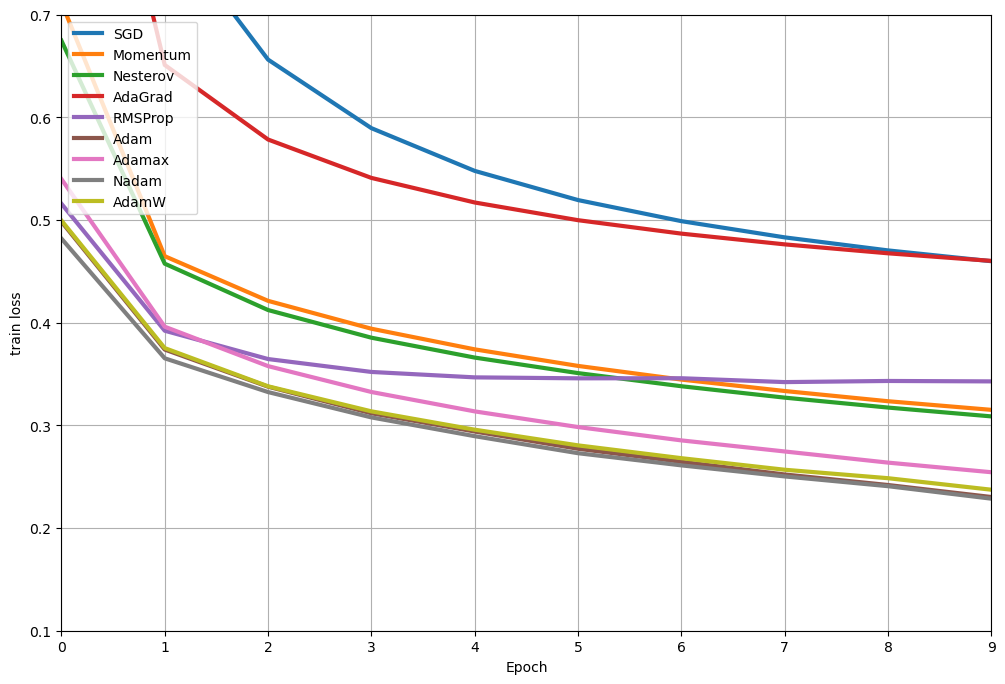

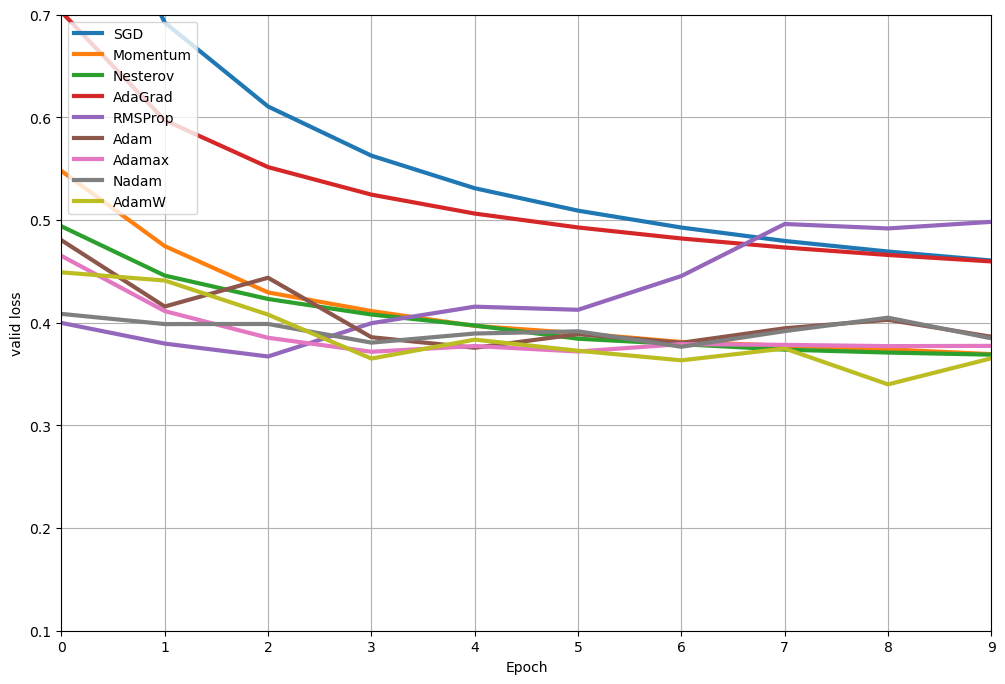

In [5]:


for loss in ("loss", "val_loss"):
    plt.figure(figsize=(12, 8))
    opt_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, opt_name in zip((history_sgd, history_momentum, history_nesterov,
                                  history_adagrad, history_rmsprop, history_adam,
                                  history_adamax, history_nadam, history_adamw),
                                 opt_names.split()):
        plt.plot(history.history[loss], label=f"{opt_name}", linewidth=3)

    plt.grid()
    plt.xlabel("Epoch")
    plt.ylabel({"loss": "train loss", "val_loss": "valid loss"}[loss])
    plt.legend(loc="upper left")
    plt.axis([0, 9, 0.1, 0.7])
    plt.show()

### 6. Learning Rate


### 6. Finding the best Learning Rate


/Users/yunjaecho/Git/practical_ml_dl/env/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 928us/step - accuracy: 0.2681 - loss: 2.1110


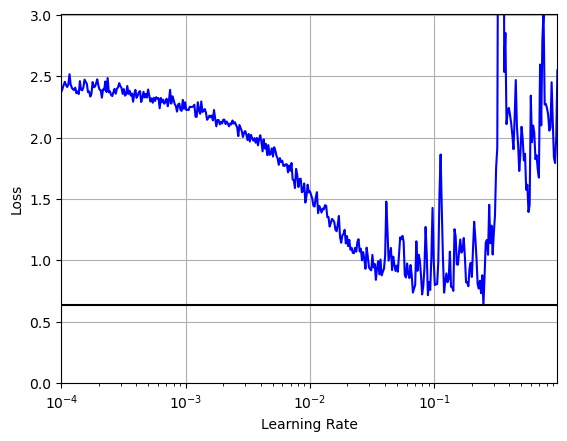

In [22]:


K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor  # 학습률 증가 계수
        self.rates = []       # 학습률 기록
        self.losses = []      # 배치 손실 기록

    def on_epoch_begin(self, epoch, logs=None):
        self.sum_of_epoch_losses = 0  # 에포크 손실 초기화

    def on_batch_end(self, batch, logs=None):
        mean_epoch_loss = logs["loss"]  # 현재까지 평균 손실
        new_sum_of_epoch_losses = mean_epoch_loss * (batch + 1)  # 누적 손실 합 계산
        batch_loss = new_sum_of_epoch_losses - self.sum_of_epoch_losses  # 배치 손실 계산
        self.sum_of_epoch_losses = new_sum_of_epoch_losses
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))  # 학습률 저장
        self.losses.append(batch_loss)  # 배치 손실 저장
        
        self.model.optimizer.learning_rate.assign(self.model.optimizer.learning_rate * self.factor)  # 학습률 증가


def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=1e-4, max_rate=1):
    init_weights = model.get_weights()  # 초기 가중치 저장
    iterations = math.ceil(len(X) / batch_size) * epochs  # 총 배치 수 계산
    factor = (max_rate / min_rate) ** (1 / iterations)  # 학습률 증가 계수 계산
    init_lr = K.get_value(model.optimizer.learning_rate)  # 초기 학습률 저장
    model.optimizer.learning_rate.assign(min_rate)  # 초기 학습률 설정
    exp_lr = ExponentialLearningRate(factor)  # 콜백 생성
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])  # 학습 진행
    model.optimizer.learning_rate.assign(init_lr)  # 초기 학습률 복원
    model.set_weights(init_weights)  # 모델 가중치 복원
    return exp_lr.rates, exp_lr.losses  # 학습률과 손실 반환

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses, "b")
    plt.gca().set_xscale('log')  # 학습률을 로그 스케일로 설정
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), min(rates), max(rates), color="k")  # 최소 손실 라인 표시
    plt.axis([min(rates), max(rates), 0, max_loss])  # 그래프 축 범위 설정
    plt.xlabel("Learning Rate")
    plt.ylabel("Loss")
    plt.grid()
    
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

batch_size = 128
rates, losses = find_learning_rate(model, X_train, y_train, epochs=1,
                                   batch_size=batch_size)
plot_lr_vs_loss(rates, losses)


In [27]:
model = build_model()

model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=25, callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 532us/step - accuracy: 0.6926 - loss: 0.9356 - val_accuracy: 0.8260 - val_loss: 0.4940 - learning_rate: 0.0100
Epoch 2/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 456us/step - accuracy: 0.8306 - loss: 0.4851 - val_accuracy: 0.8426 - val_loss: 0.4420 - learning_rate: 0.0100
Epoch 3/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 451us/step - accuracy: 0.8486 - loss: 0.4307 - val_accuracy: 0.8506 - val_loss: 0.4161 - learning_rate: 0.0100
Epoch 4/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 459us/step - accuracy: 0.8576 - loss: 0.4000 - val_accuracy: 0.8536 - val_loss: 0.4055 - learning_rate: 0.0100
Epoch 5/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 425us/step - accuracy: 0.8647 - loss: 0.3780 - val_accuracy: 0.8560 - val_loss: 0.3982 - learning_rate: 0.0100
Epoch 6/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 433us/step - accuracy: 0.8704 - loss: 0.3607 - val_accuracy: 0.8584 - val_loss: 0.3915 - learning_rate: 0.0100
Epoch 7/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 424us/step - accura

In [28]:
"""
1. 초기 구간에서는 학습률을 선형적으로 증가.
2. 중간 구간에서는 학습률을 선형적으로 감소.
3. 마지막 구간에서는 학습률을 극도로 낮은 값으로 줄임.
"""
class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_lr=1e-3, start_lr=None,
                 last_iterations=None, last_lr=None):
        """
        OneCycle 학습률 스케줄러 초기화.

        Args:
            iterations (int): 총 배치 수. (예: steps_per_epoch * epochs)
                             예시: len(X_train) / batch_size * n_epochs = 500 * 10 = 5000
            max_lr (float): 학습률의 최대값 (Peak Learning Rate).
                            예시: 0.2
            start_lr (float, optional): 학습률 시작값 (Warm-up의 초기값). 기본값은 max_lr / 10.
                                        예시: max_lr=0.2이면 start_lr=0.02.
            last_iterations (int, optional): 마지막 학습률 단계의 배치 수. 기본값은 총 배치 수의 10%.
                                              예시: iterations=5000이면 last_iterations=500.
            last_lr (float, optional): 마지막 학습률의 값. 기본값은 start_lr / 1000.
                                       예시: start_lr=0.02이면 last_lr=0.00002.
        """
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10  # 초기 학습률 (기본값은 max_lr의 1/10)
        self.last_iterations = last_iterations or iterations // 10 + 1 # 마지막 구간 배치 수
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.ㅠ = 0

    def _interpolate(self, iter1, iter2, lr1, lr2):
        """
        두 학습률 값 사이를 (interpolation).

        Args:
            iter1 (int): 시작 배치 번호.
            iter2 (int): 종료 배치 번호.
            lr1 (float): 시작 학습률 값.
            lr2 (float): 종료 학습률 값.

        Returns:
            float: 현재 배치에 해당하는 학습률.
        """
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0, self.half_iteration, self.start_lr,
                                   self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                   self.max_lr, self.start_lr)
        else:
            lr = self._interpolate(2 * self.half_iteration, self.iterations,
                                   self.start_lr, self.last_lr)
        self.iteration += 1
        self.model.optimizer.learning_rate.assign(lr)
        
        
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["accuracy"])
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs,
                             max_lr=0.2)
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6461 - loss: 1.0840 - val_accuracy: 0.7956 - val_loss: 0.5743
Epoch 2/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - accuracy: 0.8108 - loss: 0.5395 - val_accuracy: 0.8158 - val_loss: 0.5123
Epoch 3/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - accuracy: 0.8356 - loss: 0.4645 - val_accuracy: 0.8190 - val_loss: 0.5025
Epoch 4/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - accuracy: 0.8473 - loss: 0.4254 - val_accuracy: 0.8202 - val_loss: 0.4954
Epoch 5/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - accuracy: 0.8566 - loss: 0.3985 - val_accuracy: 0.8294 - val_loss: 0.4722
Epoch 6/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - accuracy: 0.8622 - loss: 0.3788 - val_accuracy: 0.8274 - val_loss: 0.4611
Epoch 7/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - accuracy: 0.8670 - loss: 0.3638 - val_accuracy: 0.8296 - val_loss: 0.4589
Epoch 8/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - accuracy: 0.8708 - loss: 0.3519 - va

### 7. Customized Loss&Metric Function

- **Class-Balanced Binary Cross-Entropy (CB-BCE)**
  - 클래스 불균형 문제를 해결하기 위해 라벨 빈도에 따라 가중치를 적용.
    $$
        \text{CB-BCE} = - w_i \cdot \left( y_i \cdot \log(\hat{y}_i) + (1 - y_i) \cdot \log(1 - \hat{y}_i) \right)
    $$

$$
w_i = \frac{1 - \beta}{1 - \beta^{n_i}}
$$

- **Ranking Loss**

  - 라벨 간 상관관계를 반영하여, 올바른 라벨의 점수가 잘못된 라벨의 점수보다 높도록 학습.
    $$
    \text{Ranking Loss} = \sum_{i,j} \max(0, \text{margin} - (\hat{y}_i - \hat{y}_j))
    $$

- **Class-Balanced BCE + Ranking Loss**
  $$
  \text{Final Loss} = \alpha \cdot \text{CB-BCE} + \beta \cdot \text{Ranking Loss}
  $$


| 특징                   | `class_weight`                                                                   | `sample_weight`                                       |
| ---------------------- | -------------------------------------------------------------------------------- | ----------------------------------------------------- |
| **가중치 부여 방식**   | 클래스(라벨) 단위로 적용                                                         | 개별 샘플 단위로 적용                                 |
| **적용 대상**          | `y_train`이 정수(라벨)일 때만 사용 가능                                          | `y_train`이 원-핫 인코딩이어도 사용 가능              |
| **불균형 데이터 대응** | 한 클래스가 많을 때, 해당 클래스의 가중치를 낮추고 희소한 클래스의 가중치를 높임 | 같은 클래스 내에서도 특정 샘플만 강조 가능            |
| **사용 예시**          | 클래스 0: 90%, 클래스 1: 10% → 클래스 1에 더 높은 가중치 부여                    | 클래스 1 내에서도 중요한 샘플에만 더 높은 가중치 부여 |
| **적용 방법**          | `class_weight={0: 1.0, 1: 10.0}`                                                 | `sample_weight=[1.0, 0.5, 2.0, ...]`                  |


In [4]:
import tensorflow as tf
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

input_shape = X_train.shape[1:]

class HuberLoss(tf.keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)

    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = threshold * tf.abs(error) - threshold ** 2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn


class HuberMetric(tf.keras.metrics.Mean):
    def __init__(self, threshold=1.0, name='custom_huber_metric', dtype=None):
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        super().__init__(name=name, dtype=dtype)
    
    # 한 배치(batch)마다 메트릭 값 업데이트
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        super(HuberMetric, self).update_state(metric, sample_weight)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}
    
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1),
])

model.compile(loss=HuberLoss(2.0), optimizer="nadam",
              metrics=[HuberMetric(2.0)])

sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled, y_train, epochs=10,
                    sample_weight=sample_weight)

(history.history["loss"][0],
 history.history["custom_huber_metric"][0] * sample_weight.mean())

model.save("./120/my_model_with_a_custom_metric.keras")

model = tf.keras.models.load_model(
    "./120/my_model_with_a_custom_metric.keras",
    custom_objects={
        "HuberLoss": HuberLoss,
        "HuberMetric": HuberMetric
    }
)
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/10


/Users/yunjaecho/Git/practical_ml_dl/env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step - custom_huber_metric: 1.0352 - loss: 0.5071
Epoch 2/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step - custom_huber_metric: 0.3075 - loss: 0.1548
Epoch 3/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step - custom_huber_metric: 0.2518 - loss: 0.1265
Epoch 4/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step - custom_huber_metric: 0.2283 - loss: 0.1149
Epoch 5/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step - custom_huber_metric: 0.2167 - loss: 0.1091
Epoch 6/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step - custom_huber_metric: 0.2092 - loss: 0.1053
Epoch 7/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step - custom_huber_metric: 0.2038 - loss: 0.1026
Epoch 8/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step - custom_huber_metric: 0.2003 - loss: 0.1008
Epoch 9/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step - custom_huber_metric: 0.1973 - loss: 0.0993
Epoch 10/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step - custom_huber_metric: 0.1944 - loss: 0.0978
Epoch 1/2
363/363 ━━

In [61]:
history.history

{'custom_huber_metric': [0.6583521962165833,
  0.28962016105651855,
  0.23281827569007874,
  0.2108340561389923,
  0.1999504119157791,
  0.19300642609596252,
  0.18813201785087585,
  0.18409395217895508,
  0.18154661357402802,
  0.1790149211883545],
 'loss': [0.33349132537841797,
  0.14674682915210724,
  0.11791014671325684,
  0.10649929940700531,
  0.10082095116376877,
  0.09718630462884903,
  0.09458249807357788,
  0.0924915000796318,
  0.09113796800374985,
  0.08985715359449387]}

## Custom Model

**`keras.Model`을 상속한 커스텀 모델 구성 요소**
| 구성 요소 | 설명 | 주요 역할 |
|-----------|--------------------------------|------------------|
| `__init__()` | 모델의 층(layer)과 하이퍼파라미터 정의 | 네트워크 구조 생성 |
| `call(inputs)` | 순전파(forward pass) 정의 | 데이터 입력 → 출력 변환 |
| `build(input_shape)` | 입력 데이터 크기를 기반으로 가중치 초기화 | 가중치 생성 및 배치 크기 고려 |
| `compile()` | 손실 함수, 옵티마이저, 평가 지표 설정 | 학습을 위한 설정 |
| `fit()` | 데이터 학습 | 모델 훈련 실행 |
| `evaluate()` | 테스트 데이터 평가 | 모델 성능 평가 |
| `predict()` | 입력 데이터 예측 | 새로운 데이터에 대한 예측 |
| `get_config()` | 모델 저장 및 로드 시 설정 유지 | 모델 직렬화 지원 |

---


## 같은함수


In [90]:
from keras.utils import plot_model

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)


tf.keras.backend.clear_session()
tf.random.set_seed(42)

# Define layers
normalization_layer = tf.keras.layers.Normalization()
hidden_layer1 = tf.keras.layers.Dense(30, activation="relu")
hidden_layer2 = tf.keras.layers.Dense(30, activation="relu")
concat_layer = tf.keras.layers.Concatenate() # this layer connect two dense layers horizontally
output_layer = tf.keras.layers.Dense(1)

# Construct the functional model
input_ = tf.keras.layers.Input(shape=X_train.shape[1:])
normalized = normalization_layer(input_)
hidden1 = hidden_layer1(normalized)
hidden2 = hidden_layer2(hidden1)
concat = concat_layer([normalized, hidden2]) # short path from input to hidden2 layer
output = output_layer(concat)

model = tf.keras.Model(inputs=[input_], outputs=[output])

model.summary()

model.compile(loss=HuberLoss(2.0), optimizer="nadam",
              metrics=[HuberMetric(2.0)])

sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled, y_train, epochs=10,
                    sample_weight=sample_weight)

(history.history["loss"][0],
 history.history["custom_huber_metric"][0] * sample_weight.mean())


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 8)         │         17 │ input_layer[0][0] │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 30)        │        270 │ normalization[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 30)        │        930 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 38)        │          0 │ normalization[0]… │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         39 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,256 (4.91 KB)

 Trainable params: 1,239 (4.84 KB)

 Non-trainable params: 17 (72.00 B)

Epoch 1/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 450us/step - custom_huber_metric: 1.0809 - loss: 0.5299
Epoch 2/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - custom_huber_metric: 0.6882 - loss: 0.3384
Epoch 3/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - custom_huber_metric: 0.6723 - loss: 0.3307
Epoch 4/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - custom_huber_metric: 0.6678 - loss: 0.3284
Epoch 5/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - custom_huber_metric: 0.6663 - loss: 0.3276
Epoch 6/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - custom_huber_metric: 0.6657 - loss: 0.3273
Epoch 7/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step - custom_huber_metric: 0.6653 - loss: 0.3271
Epoch 8/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - custom_huber_metric: 0.6647 - loss: 0.3268
Epoch 9/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - custom_huber_metric: 0.6648 - loss: 0.3268
Epoch 10/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - custom_huber_metric: 0.6640 - loss: 0.3265


(0.40507376194000244, np.float64(0.40767815774937904))

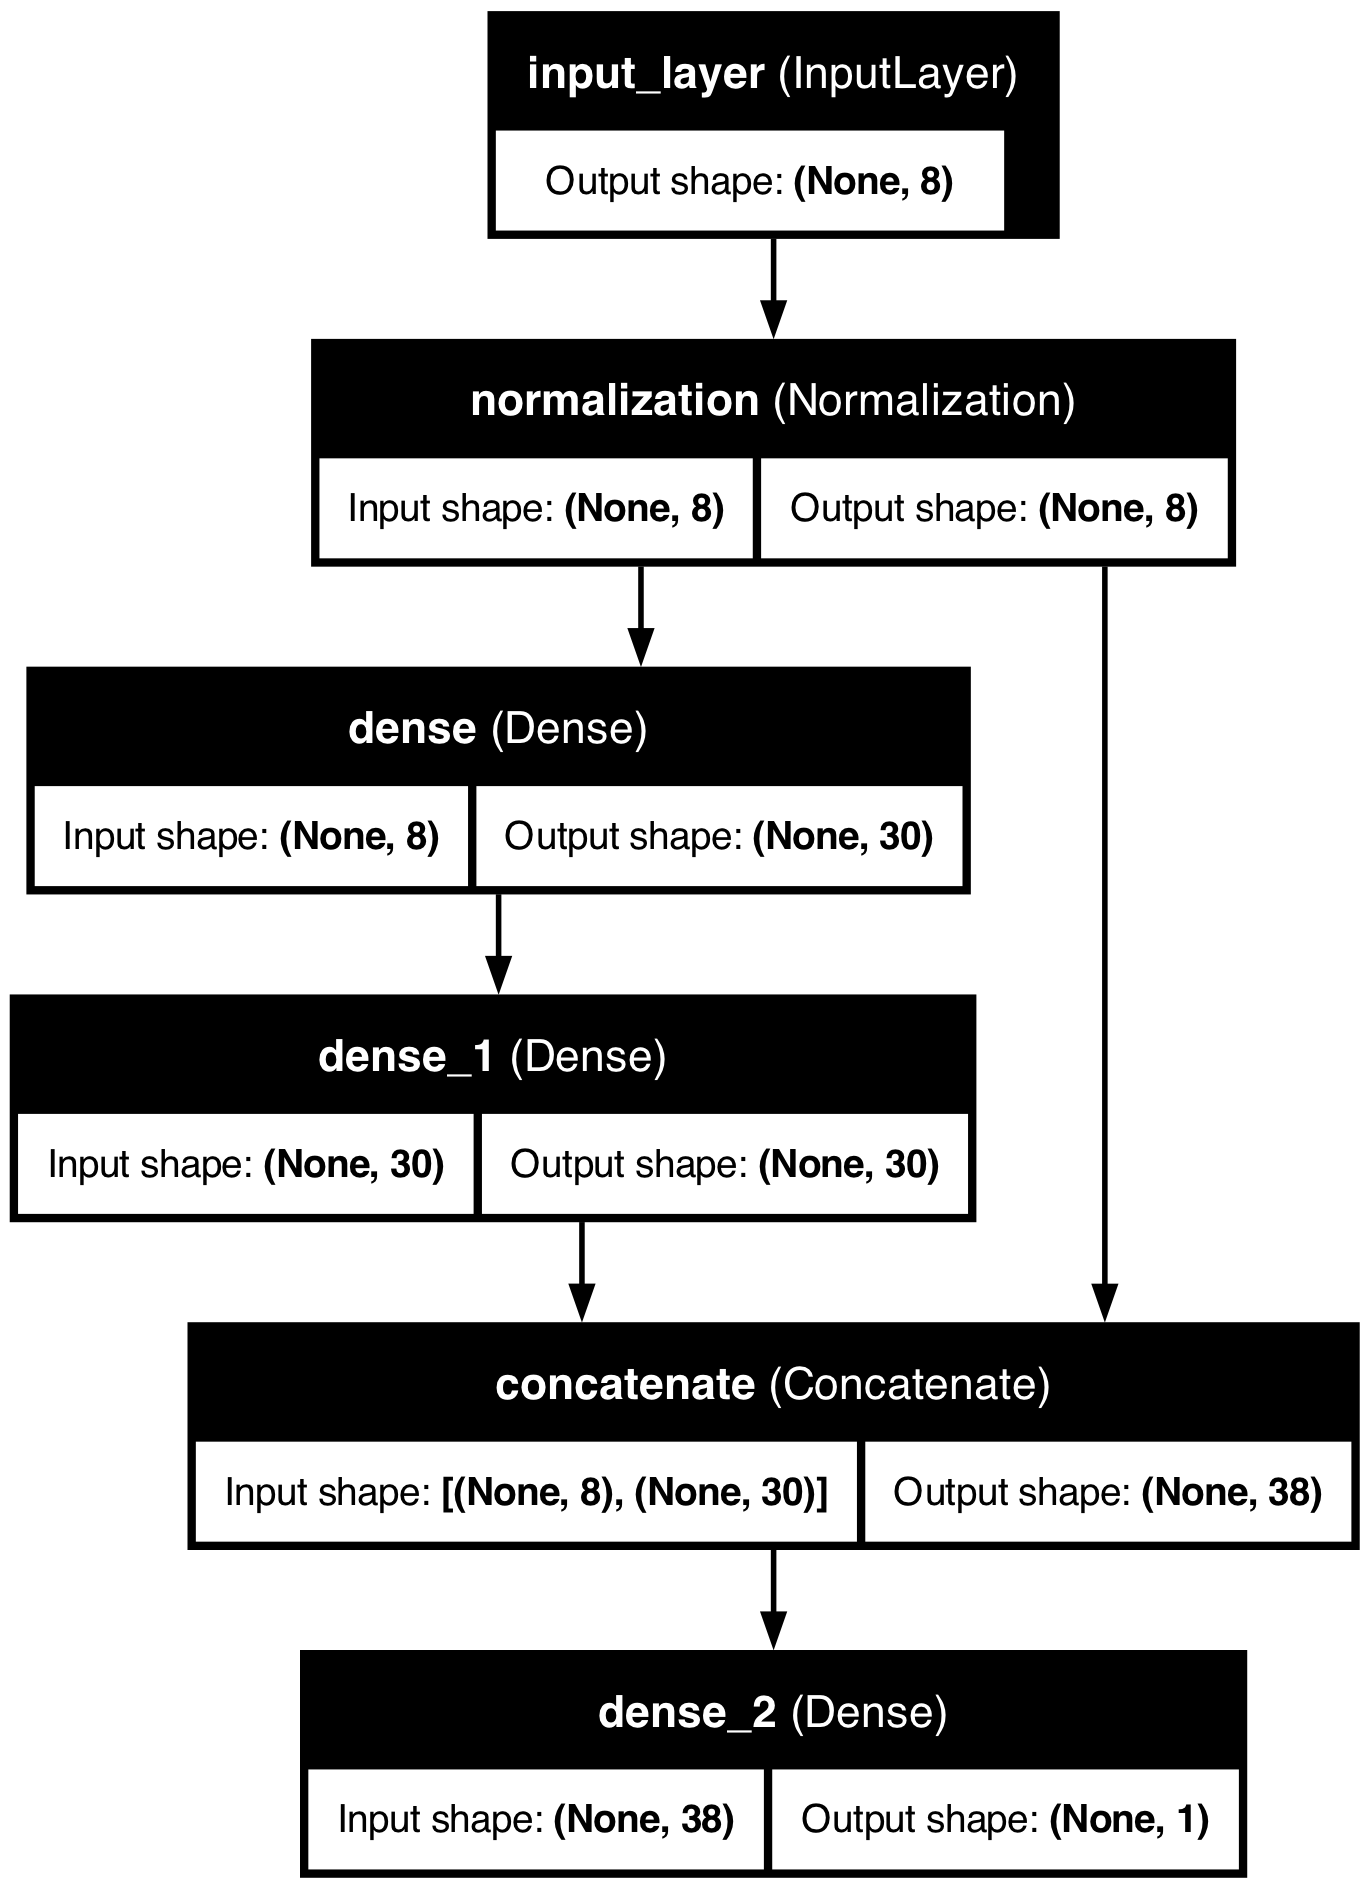

In [91]:
# 모델 그리기
plot_model(model, to_file='./100/functional_API_short_path.png', show_shapes=True, show_layer_names=True)

In [5]:
import tensorflow as tf
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import os
import numpy as np
import random

def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(2)
   tf.random.set_seed(2)
   np.random.seed(2)
   tf.keras.utils.set_random_seed(42)
   random.seed(2)

#make some random data
reset_random_seeds()

# 데이터 로드
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

tf.keras.backend.clear_session()


# 커스텀 모델 정의
class CustomHousingModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.input_layer = tf.keras.layers.InputLayer(shape=(8,))  # 🔹 입력 크기 지정
        self.normalization = tf.keras.layers.Normalization()
        self.hidden1 = tf.keras.layers.Dense(30, activation="relu")
        self.hidden2 = tf.keras.layers.Dense(30, activation="relu")
        self.concat = tf.keras.layers.Concatenate()
        self.output_layer = tf.keras.layers.Dense(1)

    def build(self, input_shape):
        """레이어들의 입력 크기를 명시적으로 정의"""
        self.normalization.build(input_shape)  # 정규화 레이어 빌드
        self.hidden1.build(input_shape)  # 첫 번째 Dense 레이어 빌드
        self.hidden2.build((None, 30))  # 두 번째 Dense 레이어 빌드
        self.concat.build([(None, 8), (None, 30)])
        self.output_layer.build((None, 38))  # Concatenate 이후 크기 (8 + 30)

        # 모델이 빌드되었음을 선언
        self.built = True
        
    def call(self, inputs):
        normalized = self.normalization(inputs)  # 정규화
        hidden1 = self.hidden1(normalized)  # 첫 번째 은닉층
        hidden2 = self.hidden2(hidden1)  # 두 번째 은닉층
        concat = self.concat([normalized, hidden2])  # Shortcut 연결
        output = self.output_layer(concat)  # 최종 출력층
        return output

# 모델 인스턴스 생성
custom_model = CustomHousingModel()

# 모델 빌드 (입력 크기 지정)
custom_model.build(input_shape=(None, X_train.shape[1]))

# 모델 요약 출력
custom_model.summary()

custom_model.compile(loss=HuberLoss(2.0), optimizer="adam",
              metrics=[HuberMetric(2.0)])

sample_weight = np.random.rand(len(y_train))
history = custom_model.fit(X_train_scaled, y_train, epochs=10,
                    sample_weight=sample_weight)

(history.history["loss"][0],
 history.history["custom_huber_metric"][0] * sample_weight.mean())



Model: "custom_housing_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 8)              │            17 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │           270 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concatenate (Concatenate)       │ (None, 38)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            39 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,256 (4.91 KB)

 Trainable params: 1,239 (4.84 KB)

 Non-trainable params: 17 (72.00 B)

Epoch 1/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step - custom_huber_metric: 1.0797 - loss: 0.5343
Epoch 2/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step - custom_huber_metric: 0.6950 - loss: 0.3451
Epoch 3/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step - custom_huber_metric: 0.6735 - loss: 0.3344
Epoch 4/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step - custom_huber_metric: 0.6673 - loss: 0.3311
Epoch 5/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step - custom_huber_metric: 0.6652 - loss: 0.3301
Epoch 6/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step - custom_huber_metric: 0.6646 - loss: 0.3298
Epoch 7/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step - custom_huber_metric: 0.6636 - loss: 0.3293
Epoch 8/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step - custom_huber_metric: 0.6638 - loss: 0.3295
Epoch 9/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step - custom_huber_metric: 0.6634 - loss: 0.3291
Epoch 10/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step - custom_huber_metric: 0.6636 - loss: 0.3293


(0.4068768620491028, np.float64(0.4077518466796753))

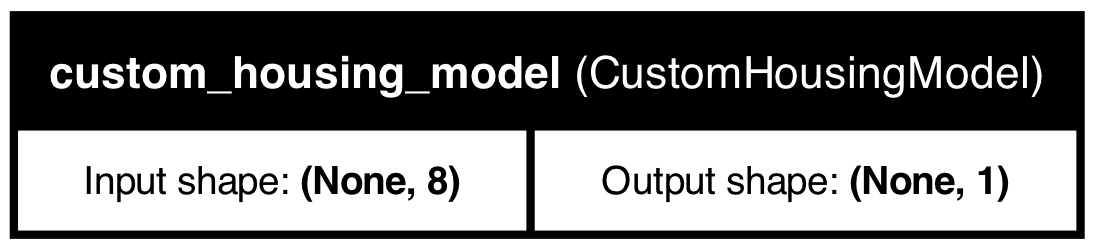

In [10]:
from keras.utils import plot_model
_ = custom_model(tf.keras.Input(shape=(8,)))  # 가짜 입력 데이터 흐름 생성

# 모델 그리기
plot_model(custom_model, to_file='./100/custom_functional_API_short_path.png', show_shapes=True, show_layer_names=True)

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)


# 추가 코드 - 데이터셋을 20개 파일로 분할하여 CSV 파일로 저장합니다.

import numpy as np # type: ignore
from pathlib import Path

def save_to_csv_files(data, name_prefix, header=None, n_parts=10):
    # 1. Define the directory path where the CSV files will be saved
    housing_dir = Path("./130/") / "datasets" / "housing" #    The directory structure is "./130/datasets/housing".
    housing_dir.mkdir(parents=True, exist_ok=True) # 2. Create the directory (including any necessary parent directories) if it doesn't already exist.
    
    # 3. Define the naming format for the CSV files.
    #    Each file will follow the format "my_<name_prefix>_<file_index>.csv".
    filename_format = "my_{}_{:02d}.csv" # format rules after ":", fill 0, minium 2 digis, d for integers

    # 4. Initialize an empty list to store the file paths of the created CSV files.
    filepaths = []
    # 5. Determine the total number of rows in the data.
    m = len(data)
    # 6. Split the indices of the data into 'n_parts' chunks to divide the dataset evenly.
    chunks = np.array_split(np.arange(m), n_parts)

    # 7. Loop over each chunk to save the corresponding rows into a separate CSV file.
    for file_idx, row_indices in enumerate(chunks):
        # 8. Generate the file path for the current chunk using the naming format.
        part_csv = housing_dir / filename_format.format(name_prefix, file_idx)
        # 9. Append the generated file path to the filepaths list for later reference.
        filepaths.append(str(part_csv))
        
        # 10. Open the file in write mode and write the data.
        with open(part_csv, "w") as f:
            # 11. If a header is provided, write it as the first line of the file.
            if header is not None:
                f.write(header)
                f.write("\n")
            # 12. Write each row of data in the current chunk as a comma-separated line.
            for row_idx in row_indices:
                f.write(",".join([str(col) for col in data[row_idx]]))
                f.write("\n")
    
    # 13. Return the list of file paths for the created CSV files.
    return filepaths


train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_csv_files(test_data, "test", header, n_parts=10)


"""
tf.data.Dataset.list_files: 파일 경로를 데이터셋으로 변환.
TextLineDataset: 파일 내용을 텍스트 라인 단위로 읽어 처리.
skip(1): 헤더 제거.
interleave: 여러 파일을 병렬로 읽고, 데이터를 하나의 데이터셋으로 결합.
"""
random_seed = 42

filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed = random_seed)

for item in filepath_dataset:
    print(item)
    
    



from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_mean, X_std = scaler.mean_, scaler.scale_
n_inputs = 8

"""
parse_csv_line
    목적: CSV 파일의 각 열에 대한 기본값(record_defaults)을 정의
    구조:
        [0.] * n_inputs: 입력 데이터(X)에 대해 기본값을 0.0으로 설정.
        n_inputs: CSV 파일의 입력 피처 개수를 나타냄.
        [tf.constant([], dtype=tf.float32)]: 출력 데이터(y)에 대해 기본값을 빈 텐서([])로 설정.
        빈 텐서는 실제 데이터가 있을 때 해당 위치를 채울 수 있도록 gka,
    예제:
        line = "1.0,2.0,3.0,4.0", defs = [0.0, 0.0, 0.0, tf.constant([], dtype=tf.float32)]
        결과: [1.0, 2.0, 3.0, 4.0] (1D 텐서 형태).
        
"""
def parse_csv_line(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype = tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)  # 스칼라 텐서 반환
    # fields = [tf.Tensor(4.5), tf.Tensor(3.2), ..., tf.Tensor(4.8), tf.Tensor(1.0)]
    
    
    #X = tf.stack([4.5, 3.2, 6.8, 2.1, 5.5, 7.2, 3.6, 4.8])
    #y = tf.stack([1.0])
    return tf.stack(fields[:-1]), tf.stack(fields[-1:]) # stack makes field to 1D tensor

def preprocess(line):
    x, y = parse_csv_line(line)
    return (x - X_mean) / X_std, y

preprocess(b'4.2083,44.0,5.3232,0.9171,846.0,2.3370,37.47,-122.2,2.782')



"""
Parameters
    - filepaths: 읽어들일 CSV 파일들의 경로 리스트. 예: ["file1.csv", "file2.csv"].
    - n_readers: 동시에 읽을 파일 개수. 병렬적으로 데이터를 읽어 성능을 향상.
    - n_read_threads: 파일 읽기 작업에 사용할 쓰레드 수. 기본값 None인 경우 TensorFlow가 자동으로 최적의 쓰레드 수를 설정.
    - n_parse_threads: 데이터 파싱에 사용할 쓰레드 수.
    - shuffle_buffer_size: 데이터 섞기(shuffling)에 사용할 버퍼 크기. 클수록 더 잘 섞이지만 메모리 사용량 증가.
    - seed: 랜덤 시드 값. 동일한 순서를 재현할 수 있음.
    - batch_size: 데이터 배치 크기. 한 번에 반환할 데이터 샘플 수.
"""

def csv_reader_dataset(filepaths, n_readers=5, n_read_threads=tf.data.AUTOTUNE,
                       n_parse_threads=5, shuffle_buffer_size=10_000, seed=42,
                       batch_size=32, repeat = True):
    dataset = tf.data.Dataset.list_files(filepaths, seed=seed) # 주어진 파일 경로(filepaths)를 기반으로 랜덤하게 섞인 데이터셋
    """
    interleave:
        여러 파일을 병렬로 읽고 데이터를 결합.
        cycle_length=n_readers: 동시에 읽을 파일 수.
        num_parallel_calls=n_read_threads: 병렬로 읽기 위한 쓰레드 수.
        tf.data.TextLineDataset(filepath).skip(1):

        CSV 파일을 한 줄씩 읽는 데이터셋 생성.
        .skip(1): CSV 파일의 헤더(첫 번째 줄)를 건너뜀.
    """
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers,
        num_parallel_calls=n_read_threads)
    
    """
    map(preprocess):
        preprocess 함수를 사용해 각 줄 데이터를 전처리.
        num_parallel_calls=n_parse_threads: 여러 쓰레드에서 병렬로 전처리 작업 수행.
        
        preprocess의 동작:
            parse_csv_line으로 데이터를 파싱하여 입력(X)과 출력(y)을 나눔.
            입력(X)은 정규화((x - X_mean) / X_std) 수행.
    """
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    """
    shuffle:
        데이터를 랜덤하게 섞어 모델 학습의 편향을 방지.
        shuffle_buffer_size=10_000: 10,000개의 데이터를 메모리에 유지하며 섞음.
    """
    dataset = dataset.shuffle(shuffle_buffer_size, seed=seed)
    
    """
    batch(batch_size):
        데이터셋을 지정된 크기(batch_size)로 나눔.
        예: batch_size=32이면 32개의 샘플이 하나의 배치로 반환.
    
    prefetch(1):
        데이터를 미리 로드하여 모델 학습 중 데이터 I/O 병목을 방지.
        학습이 진행되는 동안 다음 배치를 미리 준비.

    """
    
    dataset = dataset.batch(batch_size, drop_remainder=False).prefetch(1)
    if repeat:
        dataset = dataset.repeat()
    return dataset


#tf.keras.backend.clear_session()

train_set = csv_reader_dataset(train_filepaths, repeat= True)
valid_set = csv_reader_dataset(valid_filepaths, repeat= True)
test_set = csv_reader_dataset(test_filepaths, repeat=False)

n_train_samples = len(X_train)
n_valid_samples = len(X_valid)

batch_size = 32

steps_per_epoch = n_train_samples // batch_size  # 한 에폭 동안 처리할 배치 수
validation_steps = n_valid_samples // batch_size  # 한 에폭 동안 처리할 검증 배치 수

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape = X_train.shape[1:]),
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1),
])
model.compile(loss="mse", optimizer="sgd")


model.fit(train_set,steps_per_epoch = steps_per_epoch,
          validation_data=valid_set, validation_steps= validation_steps,
          epochs=15,
          )


    